## Procesamiento de Datos para conformar un conjunto de entrenamiento y validación

En este _notebook_ se procesan los archivos `.bin` y `.label` para formar nubes de puntos de dimensiones _(N, 4)_, siendo _N_ el número de puntos y _4_ las características `x`, `y`, `z` y `remissions`. Las características de todos los puntos serán normalizadas según su naturaleza y respecto a las nubes de puntos que conforman el conjunto de entrenamiento. Finalmente las nubes de puntos normalizadas se guardarán en archivos `.csv` divididas en los directorios correspondientes al entrenamiento y validación.



### Importar de dependencias

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import sys
import re
import matplotlib.pyplot as plt
import random as rand


from pathlib import Path
from sklearn.model_selection import train_test_split

### Cargar rutas de los archivos _.bin_ y _.label_

In [ ]:
# Windows

# point_clouds_path = Path(r"goose\val\2022-07-22_flight")
# labels_path = Path(r"goose\labels\val\2022-07-22_flight")

# Linux

# point_clouds_path = Path(r"/home/felix/Escritorio/TFG/datasets/Goose/goose_3d_val/lidar/val/2022-07-22_flight")
# labels_path = Path(r"/home/felix/Escritorio/TFG/datasets/Goose/goose_3d_val/labels/val/2022-07-22_flight")

# MacOS

point_clouds_path = Path(r"/Users/felixmaral/Desktop/TFG/datasets/goose_3d_val/lidar/val/2023-01-20_aying_mangfall_2")
labels_path = Path(r"/Users/felixmaral/Desktop/TFG/datasets/goose_3d_val/labels/val/2023-01-20_aying_mangfall_2")

### Listar y ordenar archivos _.bin_ y _.label_

In [ ]:
files_list = sorted(os.listdir(point_clouds_path))
labels_list = sorted(os.listdir(labels_path))

### Leer archivos y asignación _X Y_

In [ ]:
Y = []

# Reading .label files and adding to Y_DF
for file in labels_list:

    # reading a .label file
    label = np.fromfile(os.path.join(labels_path, file), dtype=np.uint32)
    label = label.reshape((-1))

    # extract the semantic and instance label IDs
    sem_label = label & 0xFFFF  # semantic label in lower half

    Y.append(pd.DataFrame(sem_label, columns=["sem_label"]))

In [7]:
X = []

# Reading .bin files and adding to X_DF
for file in files_list:
    scan = np.fromfile(os.path.join(point_clouds_path, file), dtype=np.float32)
    scan = scan.reshape((-1, 4))

    # put in attribute
    points = scan[:, 0:3]    # get xyz
    remissions = scan[:, 3]  # get remission

    df_point_cloud = pd.DataFrame(points, columns=["x","y","z"])
    df_point_cloud["remissions"] = remissions
    X.append(df_point_cloud)

# print(X[0:2])
# print(list_labels[0:2])

del df_point_cloud # optimizar memoria

### Estudiar Clases Semánticas

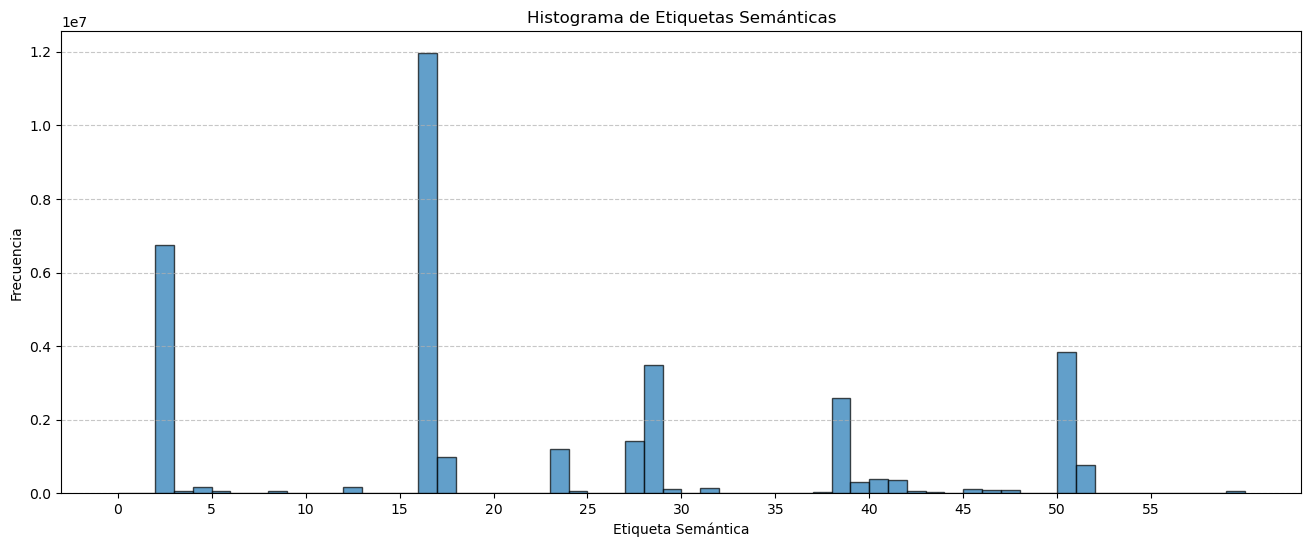

In [8]:
Y_concat = pd.concat(Y)
    
# df_list_labels

plt.figure(figsize=(16, 6))
plt.hist(Y_concat['sem_label'], 
         bins=np.arange(Y_concat['sem_label'].min(), Y_concat['sem_label'].max() + 2), 
         edgecolor='k', 
         alpha=0.7)

# Personalización del gráfico
plt.title("Histograma de Etiquetas Semánticas")
plt.xlabel("Etiqueta Semántica")
plt.ylabel("Frecuencia")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Configurar las marcas del eje X en incrementos de 5
x_ticks = np.arange(Y_concat['sem_label'].min(), Y_concat['sem_label'].max() + 1, 5)
plt.xticks(x_ticks)

plt.show()

### Estudiar de _nº puntos_ por barrido LiDAR

In [9]:
n_points_X = []

# Reading .bin files and adding to DF
for file in os.listdir(point_clouds_path):
    scan = np.fromfile(os.path.join(point_clouds_path, file), dtype=np.float32)
    scan = scan.reshape((-1, 4))

    # put in attribute
    points = scan[:, 0:3]    # get xyz
    remissions = scan[:, 3]  # get remission

    n_points_X.append(len(points))

n_points_X = np.array(n_points_X)

MIN_POINTS_X = n_points_X[n_points_X.argmin()]

print(f"La nube con menos puntos tiene: {MIN_POINTS_X}")

La nube con menos puntos tiene: 50629


### Aplicar Permutación Aleatoria para establecer un _shape_ uniforme

In [10]:
X_uniform = []
Y_uniform = []
    
for x, y in zip(X, Y):
    if len(x) >= MIN_POINTS_X:
        # Seleccionar 'MIN_POINTS_X' puntos aleatorios
        sampled_indices = np.random.choice(len(x), size=MIN_POINTS_X, replace=False)
        X_uniform.append(x.iloc[sampled_indices].reset_index(drop=True))
        Y_uniform.append(y.iloc[sampled_indices].reset_index(drop=True))
    else:
        raise ValueError(f"La nube tiene menos puntos ({len(x)}) que 'MIN_POINTS_X' ({MIN_POINTS_X}).")


### Dividir en subconjuntos

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(X_uniform, Y_uniform, train_size=0.8, random_state=42)

len(X_train)

152

### Calcular distancia máxima en _X_train_

In [12]:
# Calcular la distancia máxima global
d_max = max(
    np.sqrt((df[['x', 'y', 'z']] ** 2).sum(axis=1)).max() for df in X_train
)

# Calcular la media y desviación estándar global de 'remissions'
all_remissions = pd.concat([df['remissions'] for df in X_train])
mean = all_remissions.mean()
std = all_remissions.std()

print(f"d_max: {d_max}, mean: {mean}, std: {std}")

d_max: 199.99600219726562, mean: 11.889586448669434, std: 15.756856918334961


### Normalizar subconjuntos en función a _X_train_

- Las remisiones se normalizan en función de la _media_ y _desviación típica_ calculadas en el conjunto de entrenamiento.
- Las coordenadas espaciales se normalizan en funcion de la distancia máxima percibida en el sensor LiDAR en el conjunto de entrenamiento.

In [13]:
X_train_norm = []

for df in X_train:
    norm_df = df.copy()
    norm_df[['x','y','z']] = (df[['x','y','z']] / d_max)
    norm_df['remissions'] = (norm_df['remissions'] - mean) / std
    X_train_norm.append(norm_df)

X_val_norm = []

for df in X_val:
    norm_df = df.copy()
    norm_df[['x','y','z']] = (df[['x','y','z']] / d_max)
    norm_df['remissions'] = (norm_df['remissions'] - mean) / std
    X_val_norm.append(norm_df)

### Guardar archivos en un directorio para cada subconjunto

In [14]:
# Linux

# output_dir_x_train = "/home/felix/Escritorio/TFG/datasets_norm/goose_norm_test/x_train"
# output_dir_y_train = "/home/felix/Escritorio/TFG/datasets_norm/goose_norm_test/y_train"
# output_dir_x_val = "/home/felix/Escritorio/TFG/datasets_norm/goose_norm_test/x_val"
# output_dir_y_val = "/home/felix/Escritorio/TFG/datasets_norm/goose_norm_test/y_val"

# MacOS

output_dir_x_train = "/Users/felixmaral/Desktop/TFG/dataset_norm/goose_teesting/x_train"
output_dir_y_train = "/Users/felixmaral/Desktop/TFG/dataset_norm/goose_teesting/y_train"
output_dir_x_val = "/Users/felixmaral/Desktop/TFG/dataset_norm/goose_teesting/x_val"
output_dir_y_val = "/Users/felixmaral/Desktop/TFG/dataset_norm/goose_teesting/y_val"

os.makedirs(output_dir_x_train, exist_ok=True)
os.makedirs(output_dir_y_train, exist_ok=True)
os.makedirs(output_dir_x_val, exist_ok=True)
os.makedirs(output_dir_y_val, exist_ok=True)

# Guardar cada DataFrame en un archivo
for i, df in enumerate(X_train_norm):
    # Define el nombre del archivo, por ejemplo: dataframe_0.csv
    file_name = f"dataframe_x_{i}.csv"  # Cambia a .parquet si prefieres parquet
    file_path = os.path.join(output_dir_x_train, file_name)
    
    # Guardar el DataFrame como CSV
    df.to_csv(file_path, index=False)  # Usa index=False para omitir el índice
    print(f"Guardado: {file_path}")

for i, df in enumerate(Y_train):
    file_name = f"dataframe_y_{i}.csv"  # Cambia a .parquet si prefieres parquet
    file_path = os.path.join(output_dir_y_train, file_name)
    # Guardar el DataFrame como CSV
    df.to_csv(file_path, index=False)  # Usa index=False para omitir el índice
    print(f"Guardado: {file_path}")

# Guardar cada DataFrame en un archivo
for i, df in enumerate(X_val_norm):
    # Define el nombre del archivo, por ejemplo: dataframe_0.csv
    file_name = f"dataframe_x_{i}.csv"  # Cambia a .parquet si prefieres parquet
    file_path = os.path.join(output_dir_x_val, file_name)
    
    # Guardar el DataFrame como CSV
    df.to_csv(file_path, index=False)  # Usa index=False para omitir el índice
    print(f"Guardado: {file_path}")

for i, df in enumerate(Y_val):
    file_name = f"dataframe_y_{i}.csv"  # Cambia a .parquet si prefieres parquet
    file_path = os.path.join(output_dir_y_val, file_name)
    # Guardar el DataFrame como CSV
    df.to_csv(file_path, index=False)  # Usa index=False para omitir el índice
    print(f"Guardado: {file_path}")

Guardado: /Users/felixmaral/Desktop/TFG/dataset_norm/goose_teesting/x_train/dataframe_x_0.csv
Guardado: /Users/felixmaral/Desktop/TFG/dataset_norm/goose_teesting/x_train/dataframe_x_1.csv
Guardado: /Users/felixmaral/Desktop/TFG/dataset_norm/goose_teesting/x_train/dataframe_x_2.csv
Guardado: /Users/felixmaral/Desktop/TFG/dataset_norm/goose_teesting/x_train/dataframe_x_3.csv
Guardado: /Users/felixmaral/Desktop/TFG/dataset_norm/goose_teesting/x_train/dataframe_x_4.csv
Guardado: /Users/felixmaral/Desktop/TFG/dataset_norm/goose_teesting/x_train/dataframe_x_5.csv
Guardado: /Users/felixmaral/Desktop/TFG/dataset_norm/goose_teesting/x_train/dataframe_x_6.csv
Guardado: /Users/felixmaral/Desktop/TFG/dataset_norm/goose_teesting/x_train/dataframe_x_7.csv
Guardado: /Users/felixmaral/Desktop/TFG/dataset_norm/goose_teesting/x_train/dataframe_x_8.csv
Guardado: /Users/felixmaral/Desktop/TFG/dataset_norm/goose_teesting/x_train/dataframe_x_9.csv
Guardado: /Users/felixmaral/Desktop/TFG/dataset_norm/goose_t